# Test 4
### Fit pixelated lens potential perturbations on a smooth SIE model and an elliptical Sérsic source.
The potential perturbation here is a single localised substructure on the Einstein ring.

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint
import matplotlib.pyplot as plt
%matplotlib inline

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an SIE perturber)

In [4]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

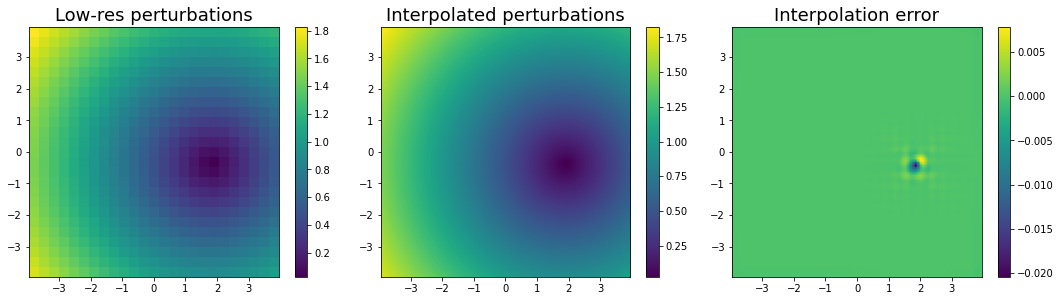

In [5]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'x_coords': x_coords_lowres, 
                            'y_coords': y_coords_lowres, 
                            'psi_grid': psi_grid_true_lowres}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1).T

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### PSF
Ignore the PSF for now.

In [6]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

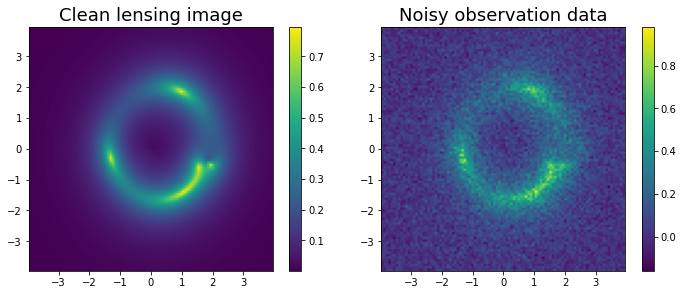

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)



# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

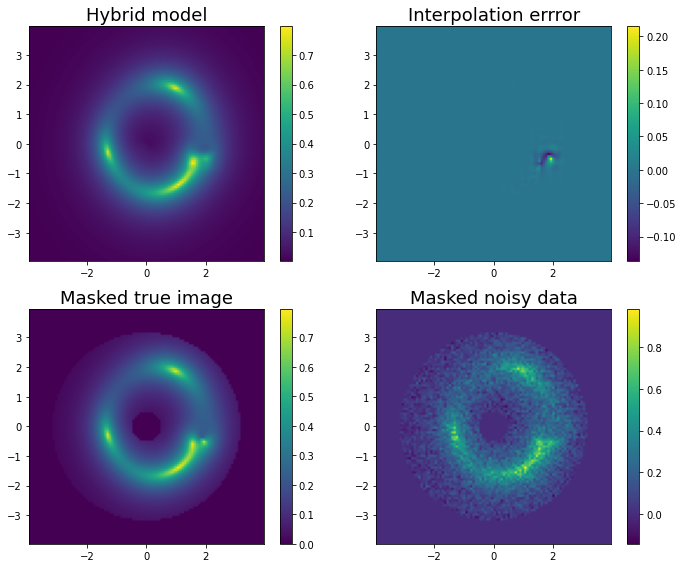

In [8]:
# Hybrid image model for fitting
hybrid_image_model = ImageModel(data_class=pixel_grid,
                                psf_class=psf,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_image_model.image(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Fit the lens potential perturbation as a pixelated grid

### Loss function
General loss function that takes all model input parameters as a nested dictionary of kwargs.

In [9]:
def create_loss_func(data, model, noise_var=None, mask=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    mask : 2D array, optional
        Binary mask, where zeros represent masked-out pixels
        (i.e. excluded) and ones represent included data.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
    if mask is None:
        mask = jnp.ones_like(data)
        
    def loss_func(params):
        # Compute reconstruction with these parameters
        rec = model.image(kwargs_lens=params['kwargs_lens_mass'],
                          kwargs_source=params['kwargs_source_light'],
                          kwargs_lens_light=params['kwargs_lens_light'])
        
        # Chi-square
        loss = jnp.sum(mask * ((data - rec)**2 / noise_var))
        # loss = jnp.sum(mask * ((data - rec)**2 / noise_var)) / mask.sum()

        # Regularisation
        # loss += ...
        
        return loss
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, hybrid_image_model, noise_var, mask=None)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters.

In [10]:
p = {'kwargs_lens_mass': kwargs_hybrid_lens_mass,
     'kwargs_source_light': kwargs_source_light,
     'kwargs_lens_light': kwargs_lens_light}

loss_true = loss(p)
print(f"loss: {loss_true:.2f}")
# print(f"grad(loss): {grad_loss(p)}")

loss: 9939.52


### Minimize the loss function over all parameters using scipy
Since scipy.minimize() takes a 1D input array of parameters, we have to make the nested dictionary of params used by the loss function above compatible with this. The code below is rather clumsy and could certainly be generalised to allow the user to decide (i.e. switch on and off) which parameters to fix and which to include in the fit.

In [11]:
@jax.jit
def func(x):
    # Assume a fixed order for input parameters x
    psi_grid = np.reshape(x, (npix_lowres, npix_lowres))
    params = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0],
                                   {'x_coords': x_coords_lowres, 
                                    'y_coords': y_coords_lowres, 
                                    'psi_grid': psi_grid}],
              'kwargs_source_light': kwargs_source_light,
              'kwargs_lens_light': kwargs_lens_light}
    return loss(params)

@jax.jit
def grad_func(x):
    return jax.grad(func)(x)

@jax.jit
def hess_func(x):
    return jax.jacfwd(jax.jacrev(func))(x)

@jax.jit
def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_func(x), v))(x)

# Alternative way to write the Hessian-vector product
# @jax.jit
# def hvp2(x, v):
#     return jax.jvp(grad_func, (x,), (v,))[1]

# Callback to track loss function
class Metrics(object):
    def __init__(self):
        self.loss_history = []
        
    def __call__(self, x, state=None):
        # Input state parameter is necessary for 'trust-constr' method
        # You can use it to stop execution early by returning True
        self.loss_history.append(func(x))
        # if state.nfev > 10:
        #     return True

In [12]:
# Check loss function of the true low-res grid
x = psi_grid_true_lowres.ravel()
print(func(x))
grad_func(x).shape

9939.51633915202


(625,)

In [13]:
# Trying to calculate the hessian directly can crash the kernel
# hess_func(x_init)

# Test the Hessian-vector product
key, subkey = jax.random.split(jax.random.PRNGKey(42))
v = jax.random.normal(subkey, shape=(npix_lowres**2,))
hvp(x, v).shape

(625,)

# Fit the perturbed pixelated potential

## No regularisation, no mask, gradient-only

In [14]:
metrics = Metrics()
x_init = np.zeros((npix_lowres, npix_lowres)).ravel()
start_time = time()
opt = minimize(func, x_init, method='BFGS', jac=grad_func, callback=metrics)
print('loss:', opt.fun)
print('message:', opt.message)
print('nfev:', opt.nfev)
print('nit:', opt.nit)
print('status: ', opt.status)
print('success:', opt.success)
print(f"time: {time() - start_time : 0.2f} s")

loss: 9310.484498891083
message: Desired error not necessarily achieved due to precision loss.
nfev: 738
nit: 650
status:  2
success: False
time:  52.30 s


In [15]:
# Reshape the final psi grid
psi_grid_rec = np.reshape(opt.x, (npix_lowres, npix_lowres))
psi_grid_rec_shifted = psi_grid_rec - (psi_grid_rec * mask_lowres).min()

p_final = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0], 
                                {'x_coords': x_coords_lowres, 
                                 'y_coords': y_coords_lowres,
                                 'psi_grid': psi_grid_rec}],
           'kwargs_source_light': kwargs_source_light,
           'kwargs_lens_light': kwargs_lens_light}

rec_image = hybrid_image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                                     kwargs_source=p_final['kwargs_source_light'],
                                     kwargs_lens_light=p_final['kwargs_lens_light'])

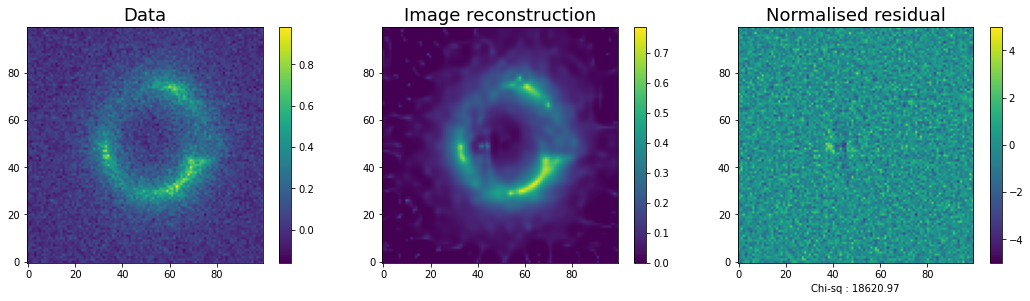

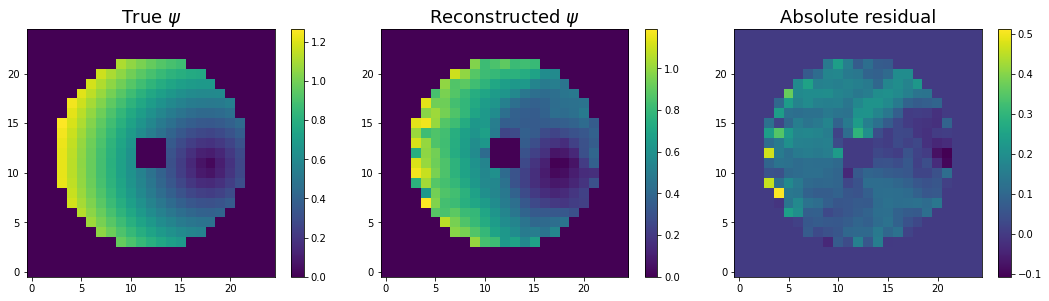

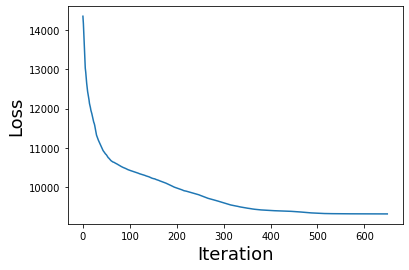

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(p_final):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true_lowres * mask_lowres, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_rec_shifted * mask_lowres, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true_lowres - psi_grid_rec_shifted) * mask_lowres, origin='lower')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS);

## No regularisation, no mask, gradient + Hessian

In [17]:
metrics = Metrics()
x_init = np.zeros((npix_lowres, npix_lowres)).ravel()
start_time = time()
opt = minimize(func, x_init, method='Newton-CG', jac=grad_func, hessp=hvp, callback=metrics)
print('loss:', opt.fun)
print('message:', opt.message)
print('nfev:', opt.nfev)
print('nit:', opt.nit)
print('status: ', opt.status)
print('success:', opt.success)
print(f"time: {time() - start_time : 0.2f} s")

loss: 9255.946279210028
message: Optimization terminated successfully.
nfev: 86
nit: 59
status:  0
success: True
time:  96.68 s


In [18]:
# Reshape the final psi grid
psi_grid_rec = np.reshape(opt.x, (npix_lowres, npix_lowres))
psi_grid_rec_shifted = psi_grid_rec - (psi_grid_rec * mask_lowres).min()

p_final = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0], 
                                {'x_coords': x_coords_lowres, 
                                 'y_coords': y_coords_lowres,
                                 'psi_grid': psi_grid_rec}],
           'kwargs_source_light': kwargs_source_light,
           'kwargs_lens_light': kwargs_lens_light}

rec_image = hybrid_image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                                     kwargs_source=p_final['kwargs_source_light'],
                                     kwargs_lens_light=p_final['kwargs_lens_light'])

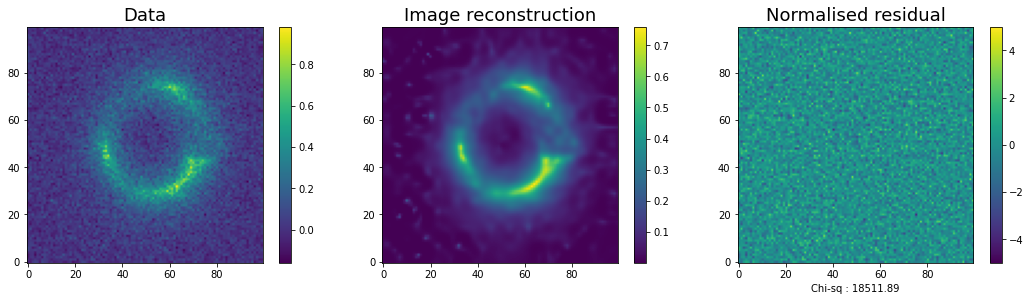

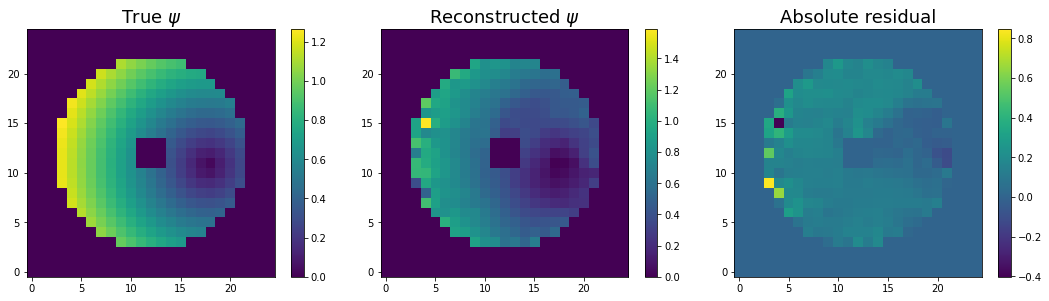

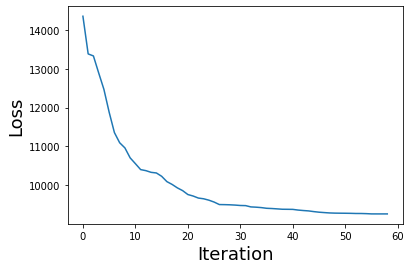

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(p_final):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true_lowres * mask_lowres, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_rec_shifted * mask_lowres, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true_lowres - psi_grid_rec_shifted) * mask_lowres, origin='lower')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS);

## Include the mask in the loss function

In [20]:
loss_masked = create_loss_func(data, hybrid_image_model, noise_var, mask=mask)

@jax.jit
def func_masked(x):
    psi_grid = np.reshape(x, (npix_lowres, npix_lowres))
    params = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0],
                                   {'x_coords': x_coords_lowres, 
                                    'y_coords': y_coords_lowres, 
                                    'psi_grid': psi_grid}],
              'kwargs_source_light': kwargs_source_light,
              'kwargs_lens_light': kwargs_lens_light}
    return loss_masked(params)

@jax.jit
def grad_func_masked(x):
    return jax.grad(func_masked)(x)

@jax.jit
def hess_func_masked(x):
    return jax.jacfwd(jax.jacrev(func_masked))(x)

@jax.jit
def hvp_masked(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_func_masked(x), v))(x)

In [21]:
# Check loss function of the true low-res grid
func_masked(psi_grid_true_lowres.ravel())

DeviceArray(4942.97519861, dtype=float64)

In [22]:
metrics = Metrics()
x_init = np.zeros((npix_lowres, npix_lowres)).ravel()
start_time = time()
opt = minimize(func_masked, x_init, method='BFGS', jac=grad_func_masked, callback=metrics)
print('loss:', opt.fun)
print('message:', opt.message)
print('nfev:', opt.nfev)
print('nit:', opt.nit)
print('status: ', opt.status)
print('success:', opt.success)
print(f"time: {time() - start_time : 0.2f} s")

loss: 4506.436926558725
message: Desired error not necessarily achieved due to precision loss.
nfev: 1244
nit: 1154
status:  2
success: False
time:  87.53 s


In [23]:
# Reshape the final psi grid
psi_grid_rec = np.reshape(opt.x, (npix_lowres, npix_lowres))
psi_grid_rec_shifted = psi_grid_rec - (psi_grid_rec * mask_lowres).min()

p_final = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0], 
                                {'x_coords': x_coords_lowres, 
                                 'y_coords': y_coords_lowres,
                                 'psi_grid': psi_grid_rec}],
           'kwargs_source_light': kwargs_source_light,
           'kwargs_lens_light': kwargs_lens_light}

rec_image = hybrid_image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                                     kwargs_source=p_final['kwargs_source_light'],
                                     kwargs_lens_light=p_final['kwargs_lens_light'])

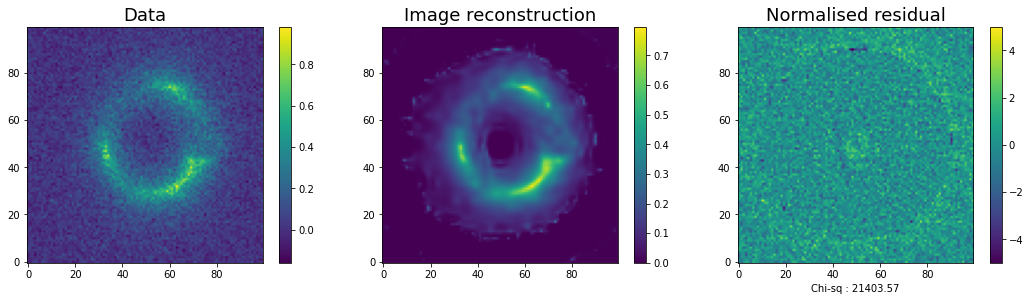

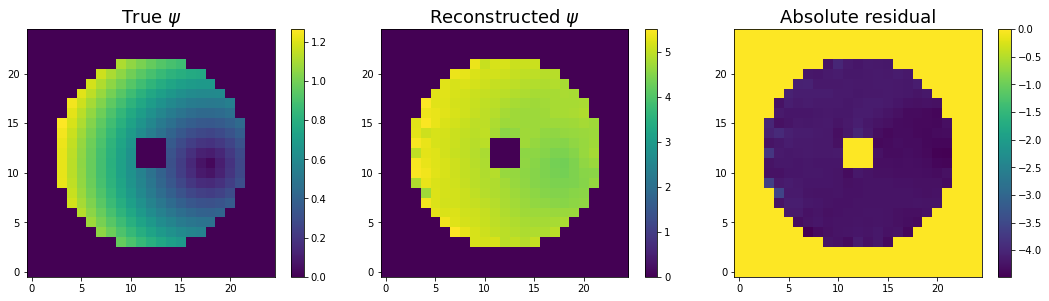

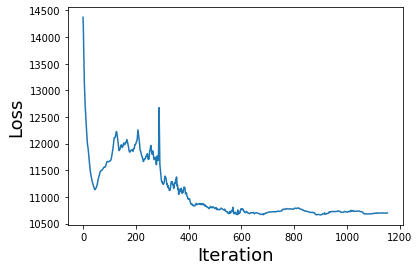

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(p_final):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true_lowres * mask_lowres, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_rec_shifted * mask_lowres, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true_lowres - psi_grid_rec_shifted) * mask_lowres, origin='lower')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS);

## Include the mask as an optimisation constraint (bounds)

In [25]:
metrics = Metrics()
x_init = np.zeros((npix_lowres, npix_lowres)).ravel()
x_lower = -100 * np.ones(npix_lowres**2) * mask_lowres.ravel()
x_upper = 100 * np.ones(npix_lowres**2) * mask_lowres.ravel()
bounds = Bounds(x_lower, x_upper)
start_time = time()
opt = minimize(func, x_init, method='trust-constr', jac=grad_func, hessp=hvp, callback=metrics, bounds=bounds)
print('loss:', opt.fun)
print('message:', opt.message)
print('nfev:', opt.nfev)
print('nit:', opt.nit)
print('status: ', opt.status)
print('success:', opt.success)
print(f"time: {time() - start_time : 0.2f} s")

loss: 9956.745976546435
message: `xtol` termination condition is satisfied.
nfev: 238
nit: 174
status:  2
success: True
time:  370.53 s


In [26]:
# Reshape the final psi grid
psi_grid_rec = np.reshape(opt.x, (npix_lowres, npix_lowres))
psi_grid_rec_shifted = psi_grid_rec - (psi_grid_rec * mask_lowres).min()

p_final = {'kwargs_lens_mass': [kwargs_hybrid_lens_mass[0], 
                                {'x_coords': x_coords_lowres, 
                                 'y_coords': y_coords_lowres,
                                 'psi_grid': psi_grid_rec}],
           'kwargs_source_light': kwargs_source_light,
           'kwargs_lens_light': kwargs_lens_light}

rec_image = hybrid_image_model.image(kwargs_lens=p_final['kwargs_lens_mass'],
                                     kwargs_source=p_final['kwargs_source_light'],
                                     kwargs_lens_light=p_final['kwargs_lens_light'])

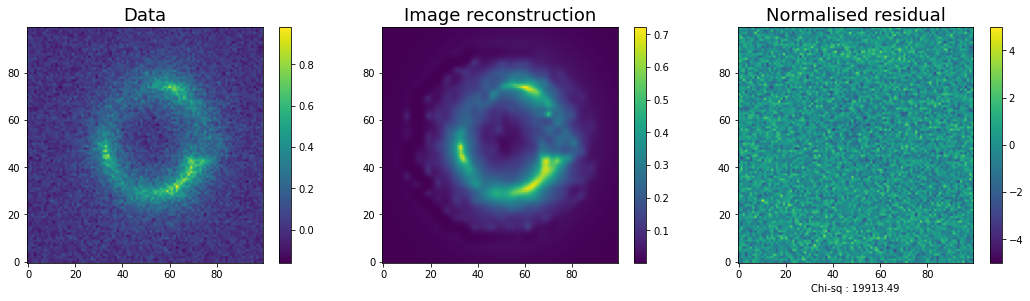

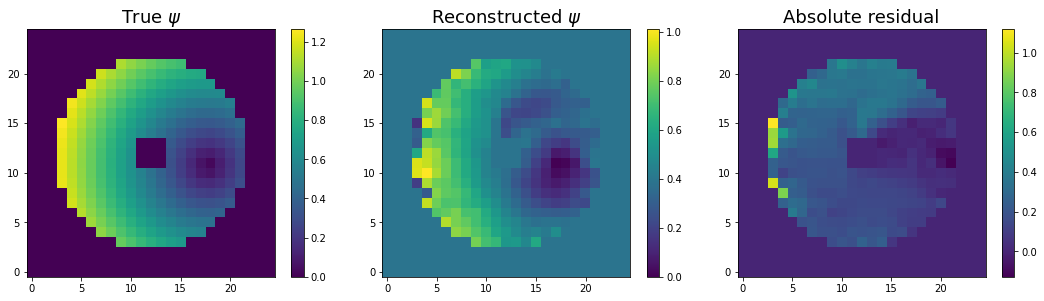

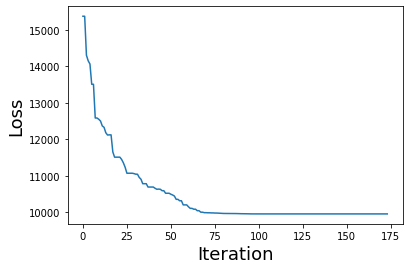

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(p_final):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true_lowres * mask_lowres, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_rec_shifted, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true_lowres - psi_grid_rec_shifted) * mask_lowres, origin='lower')
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss_history)), metrics.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS);